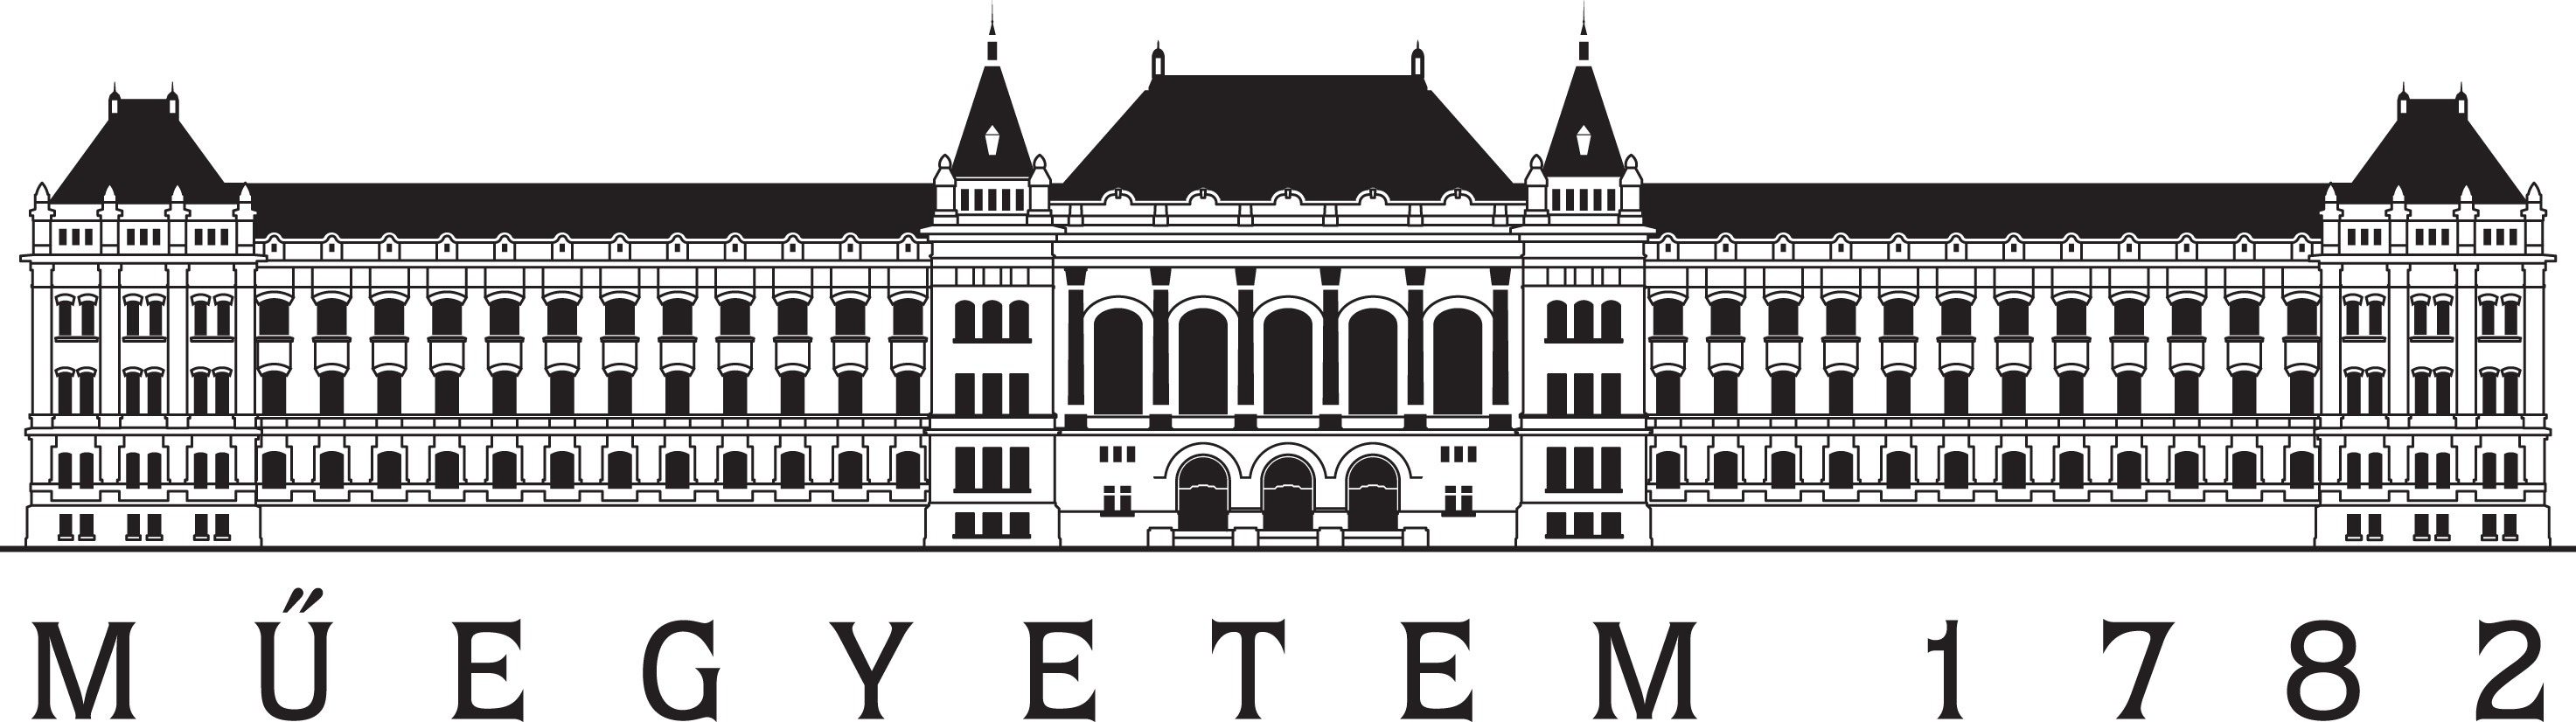

Készítette: Novoth Szilárd és Páncsics Zsombor

In [2]:
print("Please load the required input files to the folder:")
print("/content/input/metadata.tsv")
from tensorflow import keras

Please load the required input files to the folder:
/content/input/metadata.tsv


In [3]:
!python -V

Python 3.6.9


In [6]:
# Loading the outputs of word2vec
with open('/content/input/metadata.tsv', 'r') as fp:
    lines_of_wtovec_string = fp.readlines()

with open('/content/input/vectors.tsv', 'r',encoding='utf-8') as fp:
    lines_of_wtovec_vec = fp.readlines()


# Building the dictionary
i=0
dictionary = dict() #make an empty dict
for line in lines_of_wtovec_string:
    dictionary[lines_of_wtovec_string[i][:-1]] = lines_of_wtovec_vec[i][:-1]
    i=i+1
    
# Conversion: words->indicies, indicies->words
words_indicies = dict((w, i) for i, w in enumerate(dictionary.keys()))
indicies_words = dict((i, w) for i, w in enumerate(dictionary.keys()))

In [7]:
# This function filters out the unnecessary symbols
# Input: txt file
# Output: transformed_words, transformed_labels
import re
def dict_transformer(path_to_txt):
  with open(path_to_txt, 'r',encoding='utf-8') as fp: 
    linesofdatabasetrain = fp.readlines()

  transformed_words = []
  transformed_labels = []
  for line in linesofdatabasetrain:
    line = re.sub('[<>]', '', line) #hulye jelek kiszurese
    wordsarray = line[:-1].split(' ') #minus1 a \n kiszuresere
    for word in wordsarray:
      #print(word)
      try:
        transformed_labels.append(words_indicies[word])
        word=dictionary[word]
        transformed_words.append(word)
      except:
        transformed_labels.append(words_indicies['[UNK]'])
        word=dictionary['[UNK]']
        transformed_words.append(word)

  return transformed_words, transformed_labels


        
        

In [8]:
# We will use these to train the model
train_data_path = '/content/input/databasetrain.txt'
wordstransfomedarraytrain, wordstransfomedarraytrain_labels = dict_transformer(train_data_path)

test_data_path = '/content/input/databasetest.txt'
wordstransfomedarraytest, wordstransfomedarraytest_labels = dict_transformer(test_data_path)

valid_data_path = '/content/input/databasevalid.txt'
wordstransfomedarrayvalid, wordstransfomedarrayvalid_labels = dict_transformer(test_data_path)

In [9]:
kappa = list(wordstransfomedarraytrain)
len(kappa)

2239217

In [10]:
import numpy as np



# This function generates the input for the model
# Input: index: here we specify at which index we start the generation from.
#               default: 0, that is we start from the beginning
#        windows_size: length(input + output), where length(output) = 1
def io_generator(index = 0, window_size = 4, input_size = 1, window_step = 1, train = True):
  if train == True:
    corpus = wordstransfomedarraytrain
    corpus_labels = wordstransfomedarraytrain_labels
  else:
    corpus = wordstransfomedarrayvalid
    corpus_labels = wordstransfomedarrayvalid_labels

  X_matrix_big = np.zeros((1, window_size - 1, 128))
  y_matrix_categorical_big = np.zeros((1, len(dictionary)))
  y_indices_big = np.zeros((1))
  X_indices_big = np.zeros((window_size - 1))
  # y_indices_big = []
  for i in range(input_size):
    float_vector = [] # for temporarly storing one line of vectors
    float_matrix = []
    for row in list(corpus[index:index+window_size]): # 0: 0 + 1 that is: 0, 1. word
      for str_number in row.split():
        float_vector.append(float(str_number))
      float_matrix.append(float_vector) # [], word0, word1
      float_vector = []
    X = float_matrix[0:-1]
    y = float_matrix[-1]
    
    
    # We also save the indicies for the specific words. 
    # These indicies represent positions in the dictionary
    # We need y_indicies to be able to one-hot encode y
    indices = corpus_labels[index:index+window_size]
    X_indices = indices[0:-1]
    y_indices = indices[-1]
    y_categorical = keras.utils.to_categorical(y_indices, len(dictionary))
    
    index = index + window_step
    
    
    X_matrix = np.atleast_3d(X)
    X_matrix = X_matrix.reshape(1, window_size - 1, 128)
    y_matrix_categorical = np.atleast_3d(y_categorical)
    y_matrix_categorical = y_matrix_categorical.reshape(1,len(dictionary))

    X_matrix_big = np.vstack((X_matrix_big, X_matrix))
    y_matrix_categorical_big = np.vstack((y_matrix_categorical_big, y_matrix_categorical))
    y_indices_big = np.vstack((y_indices_big, y_indices))
    X_indices_big = np.vstack((X_indices_big, X_indices))
    # y_indicies_big.append(y_indices)

  # X_matrix = np.delete(X_matrix_big, 0, 0)
  # y_matrix_categorical = np.delete(y_matrix_categorical_big, 0, 0)
  X_matrix = X_matrix_big

  y_indices = y_indices_big
  X_indices = X_indices_big
  y_matrix_categorical = y_matrix_categorical_big
  # return X_matrix[1:, :, :], y, X_indices[1:, :, :], y_indices[1:, :], y_matrix_categorical[1:, :]
  y2 = np.asarray(y)
  y = y2[:, np.newaxis]
  return X_matrix[1:, :, :], y, X_indices[1:, :], y_indices[1:, :], y_matrix_categorical[1:, :]

def io_generator2(index = 0, window_size = 4, input_size = 1, window_step = 1, train = True):
  if train == True:
    corpus = wordstransfomedarraytrain
    corpus_labels = wordstransfomedarraytrain_labels
  else:
    corpus = wordstransfomedarrayvalid
    corpus_labels = wordstransfomedarrayvalid_labels

  X_matrix_big = np.zeros((input_size, window_size - 1, 128))
  y_matrix_categorical_big = np.zeros((input_size, len(dictionary)))
  y_indices_big = np.zeros((input_size, 1))
  for i in range(input_size):
    float_vector = [] # for temporarly storing one line of vectors
    float_matrix = []
    for row in list(corpus[index:index+window_size]): # 0: 0 + 1 that is: 0, 1. word
      for str_number in row.split():
        float_vector.append(float(str_number))
      float_matrix.append(float_vector) # [], word0, word1
      float_vector = []
    X = float_matrix[0:-1]
    y = float_matrix[-1]
    
    
    # We also save the indicies for the specific words. 
    # These indicies represent positions in the dictionary
    # We need y_indicies to be able to one-hot encode y
    indices = corpus_labels[index:index+window_size]
    X_indices = indices[0:-1]
    y_indices = indices[-1]
    y_categorical = keras.utils.to_categorical(y_indices, len(dictionary))
    
    index = index + window_step
    
    
    X_matrix = np.atleast_3d(X)
    X_matrix = X_matrix.reshape(1, window_size - 1, 128)
    y_matrix_categorical = np.atleast_3d(y_categorical)
    y_matrix_categorical = y_matrix_categorical.reshape(1,len(dictionary))

    X_matrix_big[i, :, :] = X_matrix
    y_matrix_categorical_big[i, :] = y_matrix_categorical

  return X_matrix_big, y_matrix_categorical_big

# In our dictionary, both the keys and the values are strings
# We need to convert the dictionary.values to floats
# This is what this function does
# Input: dictionary
# Output: float_dictionary
def dictionary_to_float_dictionary(dictionary):
  float_dictionary = dict()
  for k, v in dictionary.items():
    vector = [float(str_number) for str_number in v.split()  ]
    vector = np.asarray(vector)
    float_dictionary[k] = vector
  return float_dictionary

# Now we have a dictionary with keys as strings and values as float vectors
float_dictionary = dictionary_to_float_dictionary(dictionary)






In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import LSTM # , GRU
from tensorflow.keras.optimizers import RMSprop

hist_saved = []

# Log fájl inicializálás / fejléc
with open('hyperas-fashionmnist-log.csv', 'w') as csv_file:
  csv_file.write('window_size' + ';')
  csv_file.write('n_lstm' + ';')
  csv_file.write('dropout' + ';')
  csv_file.write('optimizer' + ';')
  csv_file.write('best_val_acc' + '\n')


# Hyperparameter optimization version 1
# window_size = [3, 4, 8, 12]
# n_lstm = [32, 128, 256, 512]
# optimizer = ['rmsprop', 'adam']
dropout = np.linspace(0, 0.2, num = 2)
# optimizer = ['rmsprop', 'sgd', 'adam']

# Hyperparameter optimization version 2 - with more lstm
window_size = [12]
n_lstm = [512]
optimizer = ['rmsprop']
dropout = [0.2]


# window_size = [3, 4]
# n_lstm = [32]
# optimizer = ['rmsprop']
# dropout = [0]

hyper_iter_count = 0  
for i in range(len(window_size)):
  for j in range(len(n_lstm)):
    for k in range(len(optimizer)):
      for l in range(len(dropout)):
        # Printing
        hyper_iter_count = hyper_iter_count + 1
        tmp = len(window_size) * len(n_lstm) * len(optimizer) * len(dropout)
        print('Iteration: ' + str(hyper_iter_count) + '/' + str( tmp ))
        print('Running with values: window_size = ', window_size[i], ', n_lstm = ', n_lstm[j], ', droput = ', dropout[l], ', optimizer = ', optimizer[k])

        # Creating the model
        model = Sequential()
        model.add(LSTM(n_lstm[j], input_shape = (window_size[i] -1 , 128) , return_sequences=True)) # number of words x dimension of word matrix
        model.add(Dropout(dropout[l]))
        model.add(LSTM(n_lstm[j]))
        model.add(Dropout(dropout[l]))
        model.add(Dense(len(dictionary))) # other: y_matrix.shape[1]
        model.add(Activation('softmax'))


        model.compile(loss = 'categorical_crossentropy',
                      metrics = ['accuracy'],
                      optimizer = optimizer[k])

        # Params
        n_iterations = 200
        input_size = 10000
        window_step = 1
        index = 0 # This changes in the loop below
        
        # X_matrix_saved = []
        # y_matrix_categorical_saved = []
        for itr in range(n_iterations):
          # Generating training data
          X_matrix, y_matrix_categorical = io_generator2(index = index,
                                                                window_size=window_size[i],
                                                                input_size=input_size,
                                                                window_step = window_step)
          # Generating validation data
          X_matrix_valid, y_matrix_categorical_valid = io_generator2(index = 0,
                                                                            window_size=window_size[i],
                                                                            input_size=int(input_size * 2),
                                                                            window_step = window_step,
                                                                            train = False)
          # X_matrix_saved.append(X_matrix)
          # y_matrix_categorical_saved.append(y_matrix_categorical)

          # Early stopping, amellyel figyeljük a validációs hibát (alap beállítás)
          from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
          patience=10
          early_stopping=EarlyStopping(patience=patience, verbose=1)
          # Szintén a validációs hibát figyeljük, és elmentjük a legjobb modellt
          checkpointer=ModelCheckpoint(filepath='model_' + str(i) + str(j) + str(k) + str(l) + str(itr) + '.hdf5', save_best_only=True, verbose=0)
          tb = TensorBoard(log_dir='logs', histogram_freq=1, write_graph=1)


          history = model.fit(x = X_matrix,
                    y = y_matrix_categorical,
                    validation_data = (X_matrix_valid, y_matrix_categorical_valid),
                    batch_size=128,
                    verbose = 1,
                    epochs=100,
                    callbacks=[early_stopping, checkpointer, tb]
                    )
          index = index + input_size * window_step
          print(itr)
        # Freeing up memory
        # model = []
        X_matrix = []
        # X_matrix_saved = []
        y_matrix_categorical = []
        # y_matrix_categorical_saved = []

        # Saving history & printing
        # hist_saved.append(history)

        # index = index + input_size * window_step
        # print(itr)
        
        best_val_acc = max(history.history['val_accuracy'])
        # Log kiírása: háló struktúra, és az eredmény
        with open('hyperas-fashionmnist-log.csv', 'a') as csv_file:
          csv_file.write(str(window_size[i]) + ';')
          csv_file.write(str(n_lstm[j]) + ';')
          csv_file.write(str(dropout[l]) + ';')
          csv_file.write(str(optimizer[k]) + ';')
          csv_file.write(str(best_val_acc) + '\n')

        # Freeing up memory
        history = []
  



Iteration: 1/1
Running with values: window_size =  12 , n_lstm =  512 , droput =  0.2 , optimizer =  rmsprop
Epoch 1/100
79/79 [==============================] - 4s 47ms/step - loss: 4.7616 - accuracy: 0.2032 - val_loss: 5.0638 - val_accuracy: 0.2521
Epoch 2/100
79/79 [==============================] - 3s 34ms/step - loss: 4.1774 - accuracy: 0.2473 - val_loss: 5.4297 - val_accuracy: 0.2223
Epoch 3/100
79/79 [==============================] - 3s 35ms/step - loss: 4.0185 - accuracy: 0.2625 - val_loss: 5.4669 - val_accuracy: 0.2423
Epoch 4/100
79/79 [==============================] - 3s 35ms/step - loss: 3.9247 - accuracy: 0.2751 - val_loss: 5.5006 - val_accuracy: 0.2569
Epoch 5/100
79/79 [==============================] - 3s 35ms/step - loss: 3.8398 - accuracy: 0.2795 - val_loss: 5.3170 - val_accuracy: 0.2427
Epoch 6/100
79/79 [==============================] - 3s 35ms/step - loss: 3.7544 - accuracy: 0.2851 - val_loss: 5.5866 - val_accuracy: 0.2806
Epoch 7/100
79/79 [====================

KeyboardInterrupt: ignored

In [ ]:
# Printing best models
import pandas
df = pandas.read_csv('hyperas-fashionmnist-log.csv', delimiter=';')
df.sort_values(by=['best_val_acc'], ascending=False)

In [ ]:
# Print the best 10 models
hyperas_log = pandas.read_csv('hyperas-fashionmnist-log.csv', delimiter=';')
hyperas_best10 = hyperas_log.sort_values(by=['best_val_acc'], ascending=False).head(n=5)
hyperas_best10

In [ ]:
# Print the worst 10 models
hyperas_worst10 = hyperas_log.sort_values(by=['best_val_acc'], ascending=False).tail(n=5)
hyperas_worst10

In [ ]:
import matplotlib.pyplot as plt

for hyperparam in [ 'window_size', 'n_lstm', 'dropout', 'optimizer', 'best_val_acc']:
  ax1 = hyperas_log.plot(kind='scatter', x=hyperparam, y='best_val_acc')
  hyperas_best10.plot(kind='scatter', x=hyperparam, y='best_val_acc', color='red', ax=ax1)
  hyperas_worst10.plot(kind='scatter', x=hyperparam, y='best_val_acc', color='yellow', ax=ax1)


In [ ]:
plt.scatter(hyperas_log.optimizer, hyperas_log.best_val_acc)
plt.scatter(hyperas_best10.optimizer, hyperas_best10.best_val_acc, color='red')
plt.scatter(hyperas_worst10.optimizer, hyperas_worst10.best_val_acc, color='yellow')
plt.show()

In [ ]:
# How are the hyperparameters and the val_acc realated?
from mpl_toolkits.mplot3d import Axes3D
# Let's plot the relation of n_filters1 / n_filters2 and the best_val_acc
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter3D(hyperas_log.window_size, hyperas_log.n_lstm, hyperas_log.best_val_acc, c=hyperas_log.best_val_acc)
ax.set_xlabel('window_size')
ax.set_ylabel('n_lstm')
ax.set_zlabel('best_val_acc')
fig.colorbar(p)
plt.show()

In [ ]:
# Printing out the loss function
import matplotlib.pyplot as plt

for hist in hist_saved[:40]:
  plt.plot(hist.history['loss'])


In [ ]:
# Printing out the loss function
import matplotlib.pyplot as plt

for hist in hist_saved[:40]:
  plt.plot(hist.history['val_accuracy'])

In [ ]:
"""
for i in range(1):
  plt.plot( [np.argmax(value) for value in y_matrix_categorical_saved[i]] )

kappa = X_matrix_saved[1]
kappa.shape
for i in range(kappa.shape[0]):
  plt.plot(kappa[i, 1, :])

plt.plot( [ value in X_matrix_saved[:, 1, :]]
"""

In [ ]:
# This function return the vector form of the model output
# (First it converts it to index and the using indicies_words it 
# transformes the index to the vector form)
# Input: model_output
# Output: vector from of the model_output
def model_output_to_vector(model_output):
  szo = indicies_words[np.argmax(model_output)]
  vector = float_dictionary[szo]
  return vector

# This function deletes the first element of the input vector
# and appends a new element to the last position.
# We use this for text generation.
# Input: old_input, new_vector
# Output: new_input
def refresh_input(old_input, new_vector):
  new_input = np.zeros(old_input.shape)
  dim = old_input.shape[1]
  new_input[0,:(dim - 1), : ] = old_input[0, 1:dim, :]
  new_input[0, dim - 1, :] = new_vector
  return new_input


# mintavétel, ami újrasúlyozza a predikciót a temperature változó alapján 
# Function for sampling. It re-weights the prediction depending on the temperature variable
# Input: preds : the distribution to be re-weighted
#        temperature : changes the distribution. The heigher we set the value, the more it changes
#                      If we want to have a good impact, we encourage the user to set temperature >= 2
def sample(preds, temperature=2):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds) # Az összes lehetőség egyre szummázódjon (lásd softmax képlet)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas), preds




# This function generates text using the trained model.
# Input: input: the starting sequence
#        n_to_generate: this is how many words will be automatically generated 
#                       using "input" as starting sequence
# Output: text: the generated string
def word_generator(input, input_indicies = None, n_to_generate = 50):
  text = []
  text_indicies = []
  for i in range(n_to_generate):
    output = model.predict(input)
    output_arg, output = sample(output[0, :])
    output = np.asarray(output).astype('float32')
    output = output * 0
    output[output_arg] = 1
    # print(' Ezeknek kéne megegyezniük, de a tempearture miatt nem :) --> ', output_arg, np.argmax(output))
    text.append(indicies_words[np.argmax(output)])
    text_indicies.append(np.argmax(output))
    vector = model_output_to_vector(model_output = indicies_words[output_arg])
    new_input = refresh_input(old_input = input, new_vector = vector)
    input = new_input
  return text, text_indicies



### --- Szöveg predikálás --- ###

# Generating an input from the beginning of the corpus
# input, _, input_indicies, _, _ = io_generator(index = 0,  window_size=window_size[-1])
# Feeding the input to the text generator & predicting a text sequence.
# text, text_indicies = word_generator(input=input, input_indicies = input_indicies)

# print(' A predikált text:', text)


In [ ]:
# Evaluating the performance on a specific input
input, _, input_indicies, y_indices, y_matrix_categorical = io_generator(index = 0,  window_size=window_size[-1], input_size=1000)
model.evaluate(x=input, y=y_matrix_categorical)

32/32 [==============================] - 0s 5ms/step - loss: 5.4578 - accuracy: 0.2140


[5.457825183868408, 0.21400000154972076]

In [ ]:
"""
### --- Sequence prediction using pre-loaded model --- ###
### --- THE USER IS ABLE TO GIVE IN AN INPUT SEQUENCE --- ###
"""

try:
  from keras.models import load_model
  model = load_model('/content/model_000019.hdf5')
except:
  print("If you haven't loaded a model to the memory, please load one using the above lines")





def vec_generator(input_sequence : str):
  required_input_length = window_size[-1] - 1
  input_sequence = input_sequence.split(' ')
  if len(input_sequence) - required_input_length < 0:
    for i in range( -(len(input_sequence) - required_input_length)):
      input_sequence.insert(0, '[UNK]')
    print(" The input sequence was too short so it was modified to : " + str(input_sequence))
  vectors = np.zeros((1, required_input_length, 128))
  for i in range(len(input_sequence)):
    
    try:
      word_vec = dictionary[input_sequence[i]]
    except:
      print("The word -" + input_sequence[i] + "- cannot be found in the dicrtionary. Try something else instead.")
      return -1

    float_vector = [] # for temporarly storing one line of vectors
    for str_number in word_vec.split():
      float_vector.append(float(str_number))

    vectors[0, i, :] = np.array(float_vector, dtype=np.float32)
  return vectors


"""
### --- ADD INPUT SEQUENCE HERE --- ###
"""

# Please only have "window_size - 1" number of words. Otherwise the code might not work.
# If the sequence is shorter, we pad '[UNK]', that is "unknown" to the beginning of the sequence.
# Also make sure you have lover-cased everythin. 
# Example: 'öcsi az a kisfiú'
input_sequence = 'öcsi az a kisfiú' 
vec = vec_generator(input_sequence=input_sequence)
# Feeding the input to the text generator & predicting a text sequence.
text, text_indicies = word_generator(input=vec, input_indicies = input_indicies)

print(' The predicted text:', text)

 The input sequence was too short so it was modified to : ['[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', 'öcsi', 'az', 'a', 'kisfiú']
 The predicted text: ['nincs', 'vele', 'csak', 'is', 'karját', '[UNK]', 'kötõjel', 'a', 'elegendő', 'mögött', 'a', 'vesszõ', 'adta', 'hét', 'meglátta', 'legalább', 'nincs', 'erre', 'gyors', 'vesszõ', 'kötõjel', 'szabad', '[UNK]', 'úgy', 'hiába', 'tekintetét', 'tekintetét', 'illeti', 'és', 'friss', '[UNK]', 'véletlen', 'mintegy', 'ugyan', 'hajó', 'más', 'amelynek', 'vele', 'azt', 'vesszõ', 'belőle', 'közt', 'ugrott', 'ki', 'fordult', '[UNK]', 'saját', 'csaknem', 'vissza', 'nehogy']
